<a href="https://colab.research.google.com/github/Pheol9166/AIstudy/blob/main/NLP/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Naver sentiment analysis

In [ ]:
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# data load
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x78e4db896cb0>)

In [ ]:
train = pd.read_table('ratings_train.txt')
test = pd.read_table('ratings_test.txt')

In [ ]:
# check null
train['document'].isnull().sum(), test['document'].isnull().sum()

(5, 3)

In [ ]:
# drop null
train = train.dropna(how='any')
test = test.dropna(how='any')

train.isnull().values.any()

False

In [ ]:
# check duplicates
print(len(train['document']), len(train['document'].unique()))
print(len(test['document']), test['document'].nunique())

149995 146182
49997 49157


In [ ]:
# drop duplicates
train.drop_duplicates(['document'], inplace=True)
test.drop_duplicates(['document'], inplace=True)
len(train)

146182

In [ ]:
# tokenization
def get_stopwords():
  urllib.request.urlretrieve("https://raw.githubusercontent.com/stopwords-iso/stopwords-ko/master/stopwords-ko.txt", filename="stopwords.txt")
  with open("stopwords.txt", "r") as f:
    stopwords = f.readlines()
    stopwords = [stopword.strip() for stopword in stopwords]
  return stopwords

stopwords = get_stopwords()

In [ ]:
# tokenization func
okt = Okt()

def tokenize_text(data: list[str], stopwords: list[str]) -> list[list[str]]:
  result = []
  for text in tqdm(data):
    tokenized_text = okt.morphs(text, stem=True)
    removed_stopwords_text = [word for word in tokenized_text if not word in stopwords]
    result.append(removed_stopwords_text)

  return result

In [ ]:
X_train = tokenize_text(train['document'], stopwords)
X_test = tokenize_text(test['document'], stopwords)
X_train[:5]

 38%|███▊      | 55491/146182 [04:43<06:19, 238.74it/s]

In [ ]:
# integer encoding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.word_index

In [ ]:
threshold = 3
total = 0
rare = 0
rare_freq = 0
for word, count in tokenizer.word_counts.items():
  total += count
  if count < threshold:
    rare += 1
    rare_freq += count

print(f"전체 단어집합 크기: {total}")
print(f"{threshold - 1} 이하의 단어 수: {rare}")
print(f"희귀 단어 비율: {(rare / len(tokenizer.word_index)) * 100}% ")
print(f"희귀 단어 빈도 비율: {(rare_freq / total) * 100 }%")

In [ ]:
vocab_size = total - rare + 1

tokenzier = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = train['label']
y_test = test['label']

In [ ]:
def drop_empty(data):
  drop_datas = [i for i, text in enumerate(data) if len(text) < 1]
  return drop_datas

drop_datas = drop_empty(X_train)
X_train = np.delete(X_train, drop_datas, axis=0)
y_train = np.delete(y_train, drop_datas, axis=0)

In [ ]:
# padding
mean_len = sum(map(len, X_train)) / len(X_train)
mean_len

In [ ]:
plt.hist([len(text) for text in X_train], bins=50)
plt.show()

In [ ]:
max_len = 30
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

#### Sequential API

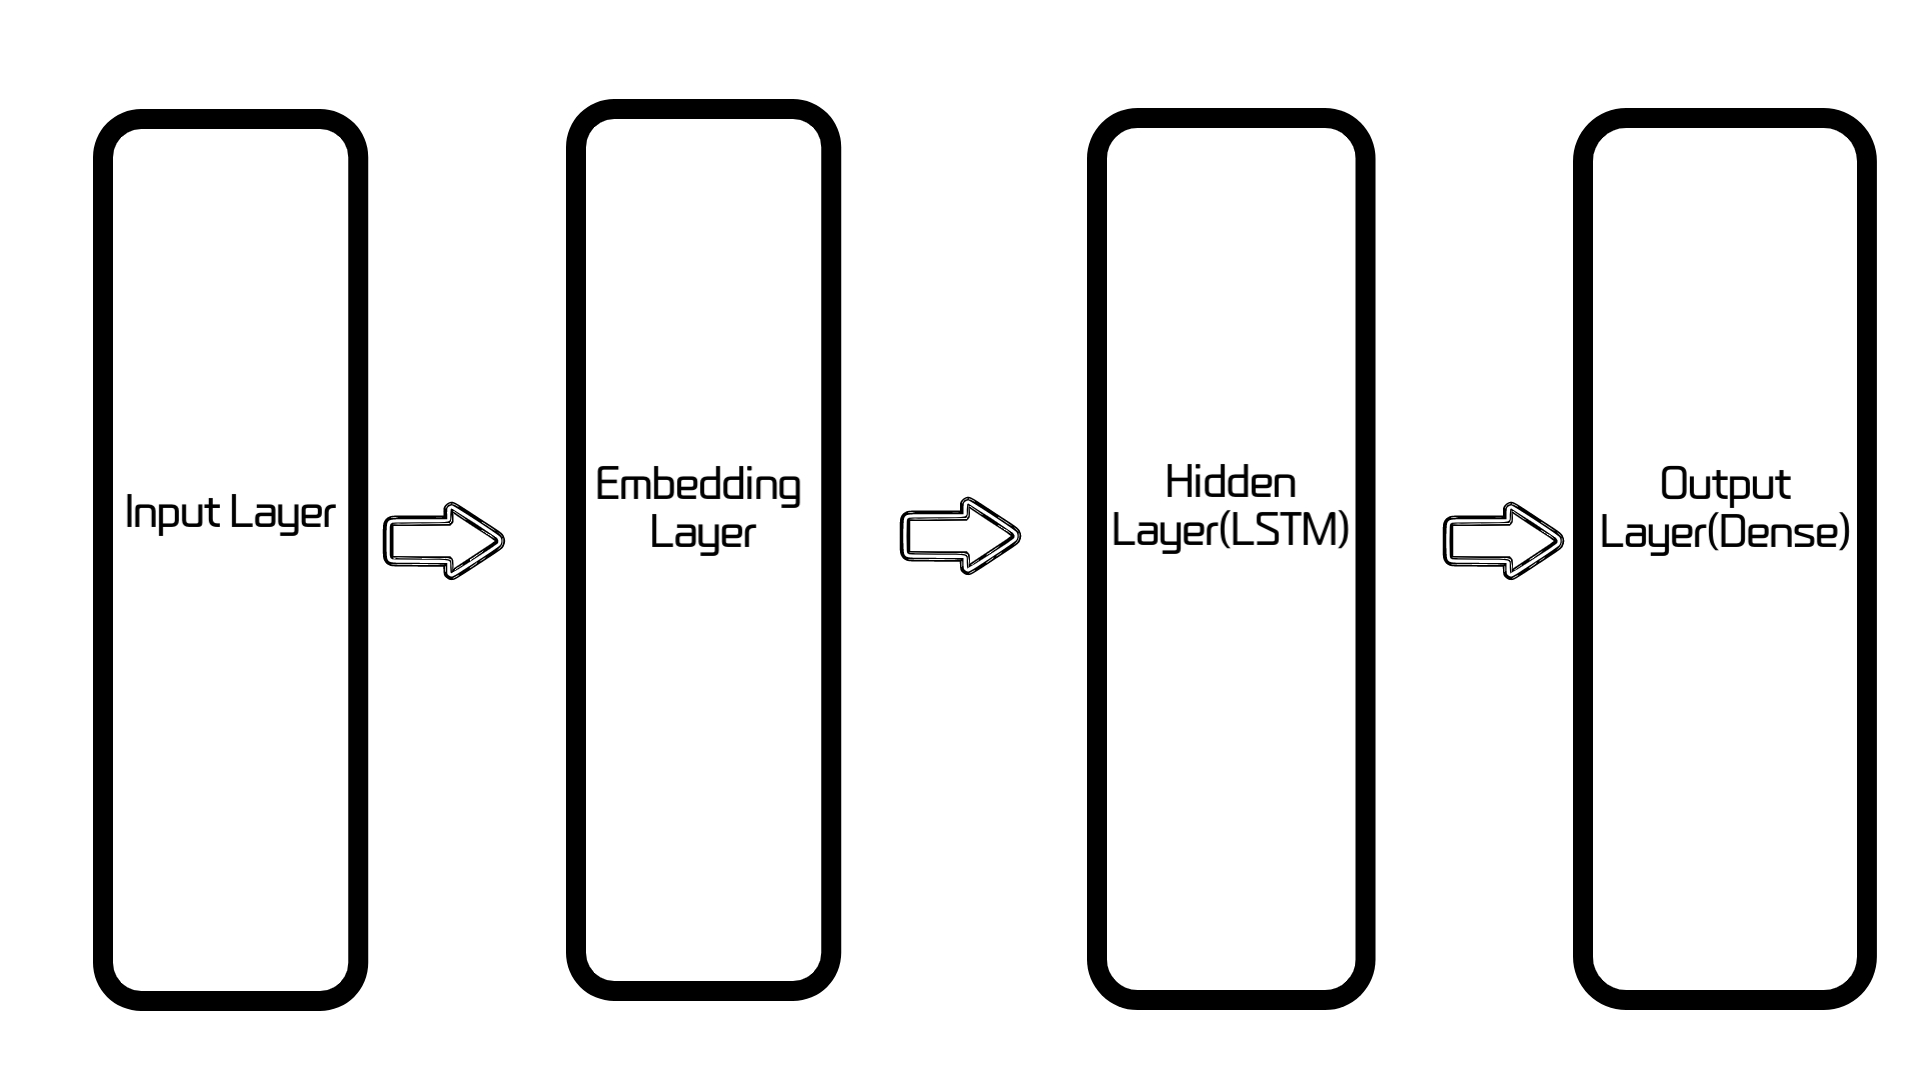

In [ ]:
# binary classification
input_len = 100
hidden_unit = 128

model = Sequential()
model.add(Embedding(vocab_size, input_len))
model.add(LSTM(hidden_unit))
model.add(Dense(1, activation='sigmoid'))

#### Functional API

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [ ]:
inputs = Input(shape=(input_len,))
embed = Embedding(vocab_size, input_len)(inputs)
hidden = LSTM(hidden_unit)(embed)
output = Dense(1, activation='sigmoid')(hidden)

model = Model(inputs=inputs, outputs=output)

#### Subclassing API

In [ ]:
import tensorflow as tf

In [ ]:
class NaverSentAnalysis(tf.keras.Model):
  def __init__(self):
    super(NaverSentAnalysis, self).__init__()
    self._vocab_size = vocab_size
    self._input_len = input_len
    self._hidden_unit = hidden_unit
    self.embed_layer = tf.keras.layers.Embedding(self._vocab_size, self._input_len)
    self.h = LSTM(self._hidden_unit)
    self.d = Dense(1, activation='sigmoid')

  def call(self, x):
    x = self.embed_layer(x)
    x = self.h(x)
    return self.d(x)

#### compile and train

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
mc = ModelCheckpoint('train_model.h5', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=64, validation_split=0.2)

In [ ]:
model.summary()

#### validation

In [ ]:
model = load_model('train_model.h5')
model.evaluate(X_test, y_test)

#### predict

In [ ]:
def predict(text):
  stopwords = get_stopwords()

  text = re.sub(r"[^가-힣]", "", text)
  text = okt.morphs(text, stem=True)
  text = [word for word in text if not word in stopwords]
  encoded_text = tokenizer.texts_to_sequences([text])
  padded_text = pad_sequences(encoded_text, maxlen = max_len)
  score = float(model.predict(padded_text))
  if score > 0.5:
    print("긍정 리뷰입니다.")
  else:
    print("부정 리뷰입니다.")

example = input()
predict(example)